<div style="background-color:#1434A411; padding:0.5em; border:3px solid darkblue">
<h1 style="font-weight:bold; color:#1434A4; margin-bottom:0.2em">Final Project</h1>
<p style="font-weight:bold">Harrison Tran // AOS 573</p>
</div>

## Introduction

This Jupyter notebook involves novel analyses and visualizations regarding my topic of research that have not been previously performed elsewhere. My research involves analyzing the correlation between satellite-derived precipitation estimates and qualitative ship reports, with the hope of using those correlations to construct a more confident climatology of maritime precipitation. Thus far, my research has primarily been concerned with assessing the inventory of ship observations that are available and how they have varied over the study period (1950-2019). 

While my mentor, Dr. Grant Petty, has worked with me on this research, the work performed for this final project was done entirely indepdently.

This notebook — and final AOS 573 project — takes what I've done as part of my research to the next step, and hopefully the results generated here for the first time or the workflows performed may be used as part of a future publication. None of the workflows done here were performed previously in relation to my research project.

The goal of this notebook is to process and visualize temporally and spatially-defined subsets of the ship observation data and seeing how they compare with coterminous satellite-derived estimates. This workflow will walk through summary visualizations of of the ship observation data and the satellite-derived precipitation estimates, building an understanding of their spatial and aggregated characteristics. First, data from IMERG will be presented and analyzed. Then, data from ICOADS will be presented and analyzed, in the hopes of demonstrating that qualitative ship observations may be related to the IMERG data and thus elucidate spatial information about precipitation patterns, in the hope of producing a quantifiable relationship between satellite-derived and qualitative ship datasets that can underlie the broader research effort to build a pre-satellite oceanic rainfall climatology.

For this analysis, we will only be looking at data from 2010, which keeps the uploaded data under 1 GB. While this may hamstring the analysis somewhat, the analyses performed as part of this project will hopefully be instructive for my future efforts in this research topic.

**GUIDING QUESTION**
> Does the collection of qualitative maritime observations taken by human-observers resemble coterminous quantitative satellite-derived precipitation estimates?

### Imports
We will begin by importing several Python libraries which will all be used in the workflow presented in this data analysis workbook. The environment used for this project is the AOS 573 environment, which has been exported to `environment.yml` within this repository.

In [1]:
# Data manipulation, storage, and calculation
import numpy as np                       # Numpy, for mathematical operations
import xarray as xr                      # XArray, for gridded data
import pandas as pd                      # Pandas, for data tables
from scipy import stats                  # Scipy, for statistics
import cftime                            # cftime, for netCDF time management
from datetime import datetime, timedelta # datetime, for general time management and parsing

# Data visualization
import matplotlib.pyplot as plt          # Matplotlib
import matplotlib.gridspec as gridspec   # Matplotlib Gridspec
import matplotlib.colors as colors       # Matplotlib colors
import matplotlib.ticker as mticker      # Matplotlib plot ticks
import cartopy.crs as ccrs               # Cartopy projections
import cartopy.feature as cfeature       # Cartopy features
import cartopy.util as cutil             # Cartopy utilities

## Data Acquisition

The crux of this project is to relate quantitative ship observations to satellite-derived precipitation estimates over water. The ship report data originates from [International Comprehensive Ocean-Atmosphere Data Set (ICOADS)](https://icoads.noaa.gov/), which was first created in the 1980s as part of an international effort to aggregate historical ship reports from disparate data sources into a unified, quality-controlled dataset. While there are many gridded datasets dealing with global precipitation which incorporate satellite data, for this analysis we will use [Integrated Multi-satellitE Retrievals for GPM (IMERG)](https://gpm.nasa.gov/data/imerg), which is more purely satellite-derived, with data arising from passive microwave sensors from the Global Precipitation Measurement (GPM) constellation. Before working with the data, we will need to acquire the data from ICOADS and IMERG. This section handles that data acquisition.

### ICOADS (International Comprehensive Ocean-Atmosphere Data Set)

ICOADS (version 3) data was acquired from the [NCAR ICOADS page](https://rda.ucar.edu/datasets/ds548.0/?hash=access). For this project we will be looking at solely data from 2010. The data request was performed using NCAR's [data subset](https://rda.ucar.edu/datasets/ds548.0/#!imma1_subset.php?gindex=1&_da=y) feature, with the following request parameters:
- [x] Data from 2010-01-01 to 2010-12-31, with global coverage
- [x] Enhanced Filtering, with no customized flag/filtering options 
- [x] `WW*`, the present weather code, was the only core data parameter selected
- [x] .gz file compression and combined output into .tar files
- [x] Only the Platform Type `5`, representing ships, was selected

Information on what the fields in ICOADS mean can be found in [this PDF documentation](https://icoads.noaa.gov/e-doc/imma/R3.0-imma1_short.pdf)

> **Note**: Requesting and downloading this data requires an NCAR account

The data arrives as a `.gz` file, which needs to be unzipped and preferably renamed to a more accessible filename. By the time you read this notebook, that file would have already been unzipped, so the following lines have been commented out:

In [2]:
# ! gzip -d ICOADS_R3.0_Rqst606503_20100101-20101230.csv.gz
# ! mv ICOADS_R3.0_Rqst606503_20100101-20101230.csv.gz icoads2010.csv

### IMERG (Integrated Multi-satellitE Retrievals for GPM)

IMERG data was acquired from the [NASA GES DISC IMERG page](https://disc.gsfc.nasa.gov/datasets/GPM_3IMERGM_06/summary?keywords=IMERG). This data involves monthly aggregations of satellite-derived rainfall. To align with the ICOADS data, only data from 2010 was utilized. The data request was performed using the GES DISC "Subset / get data" option, available on the previously linked page, with the following request parameters:
- [x] Download method was "Get File Subsets using OPeNDAP"
- [x] Data date range refined to 2010-01-01 to 2011-01-01
- [x] Only the `precipitation` variable was selected
- [x] The `netCDF` file format was selected

> **Note**: Requesting and downloading this data requires a NASA Earthdata account

This ordering process results in a list of direct download links to IMERG netCDF files. Unlike the ICOADS data, the IMERG data does not need further processing to alter the data into a form usable in Python. Hooray! The data produced through this request can be found in the `IMERG/` directory.

## Exploring the IMERG Dataset

We will first look at the IMERG satellite-derived dataset. While satellite-derived precipitation estimates can be faulty and unreliable in many circumstances, in many cases it is also our best method of precipitation estimation, especially in regions where data is sparse. IMERG shouldn't necssarily be considered "truth", but given the coarseness and paucity of ship observations, it serves as a useful benchmark for comparison and it's what we have to measure the qualitative ship reports from ICOADS against.

The `IMERG/` directory is a set of netCDF files, with each representing a month of precipitation estimates from 2010. This means we can make use of xarray's [`open_mfdataset`](https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html) function to open the files collectively as a single dataset. As a first step after opening the dataset, we should investigate the dataset's coordinate structure and variables:

In [3]:
imerg_ds = xr.open_mfdataset('IMERG/*.nc4') # Read in netCDF files as a single dataset
imerg_ds # Display the data for examination

<xarray.Dataset>
Dimensions:        (time: 12, lon: 3600, lat: 1800)
Coordinates:
  * lat            (lat) float32 -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * lon            (lon) float32 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9
  * time           (time) object 2010-01-01 00:00:00 ... 2010-12-01 00:00:00
Data variables:
    precipitation  (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
Attributes:
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-MONTH/06;\nDOIa...
    FileInfo:                        DataFormatVersion=6a;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         2022-12-14 05:09:38 GMT Hyrax-1.16.3 htt...

As anticipated, the IMERG data is a spatial 0.1 x 0.1 degree gridded dataset estimating monthly average precipitation rates (in mm/hr) for each month in 2010. It's worth noting that the `precipitation` field, which contains the actual precipitation estimates, is stored as `(time, lon, lat)`. While this may be fine in many cases, this ordering does not play friendly with `xESMF`, nor does it display properly oriented plots with the default `xarray` plotting operations. Thus, we turn to the [`transpose`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.transpose.html) function to adjust the `precipitation` field to a more conventional `(time, lat, lon)` ordering.

In [4]:
imerg_ds['precipitation'] = imerg_ds.precipitation.transpose('time','lat','lon') # Transpose ordering of precipitation coordinates

### Masking Out Land in IMERG

It wouldn't make much sense to analyze or make judgements regarding the full spatial IMERG dataset since ICOADS contains only *ship* observations. In comparing the two datasets, we don't want to factor in over-land IMERG precipitation estimates because ICOADS would not sample precipitation over land. Before we do any calculation or comparison, we need to ignore any over-land precpitation. Thankfully, NASA provides a [land/sea mask relevant to the IMERG 0.1 x 0.1 degree grid](https://gpm.nasa.gov/data/directory/imerg-land-sea-mask-netcdf), which we will be using to filter out land from the IMERG precipitation dataset.

This data was originally provided as a `.gz` file, so we would have needed to unzip the file. By the time you're reading this workbook, that step will have already been performed, so the following code snippet which handles unzipping the file has been commented out:

In [5]:
# ! gzip -d IMERG_land_sea_mask.nc.gz

It would be useful to take a quick look at the land/sea mask to see how it is put together:

In [6]:
imerg_land_ds = xr.open_dataset('IMERG_land_sea_mask.nc')
imerg_land_ds

<xarray.Dataset>
Dimensions:      (lon: 3602, lat: 1800)
Coordinates:
  * lon          (lon) float64 -0.05 0.05 0.15 0.25 ... 359.8 359.9 360.0 360.1
  * lat          (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    landseamask  (lat, lon) float32 ...

The land/sea mask is contained within the `landseamask` variable, which describes the percent water surface coverage. To align the land/sea mask with the IMERG precipitation array, we can adjust the longitude field to be extend from -179.95 to 179.95, which requires trimming the land/sea mask and reindexing its `lon` coordinate. This mask will then be augmented to the `imerg_ds` IMERG dataset.

> **Note**: [This StackOverflow post](https://stackoverflow.com/questions/53345442/about-changing-longitude-array-from-0-360-to-180-to-180-with-python-xarray) provided useful information on how to adjust a strictly-positive global longitude coordinate system in xarray to a negative and positive one.

In [7]:
imerg_landsea = imerg_land_ds.landseamask # Extract the land/sea max
imerg_landsea = imerg_landsea.sel( lon = slice( -5e-2, 3.5985e2 ) ) # Trim the last two longitudes to match the IMERG grid

imerg_landsea.coords['lon'] = (imerg_landsea.coords['lon'] + 180) % 360 - 180 # Adjust longitude field to be negative for west to positive for east
imerg_landsea = imerg_landsea.sortby('lon') # Reindex longitudes to be monotonic

In [9]:
# Add the land/sea mask to the IMERG dataset
imerg_landsea_array = xr.DataArray( imerg_landsea.values, dims = ['lat', 'lon'], coords = { 'lon': imerg_ds.lon, 'lat': imerg_ds.lat } )
imerg_landsea_array.attrs['units']='%'
imerg_ds['surface_water_coverage'] = imerg_landsea_array
imerg_ds['surface_water_coverage'].attrs['units'] = '%'

To get a look at what the land/sea mask looks like, we can make a quick spatial plot:

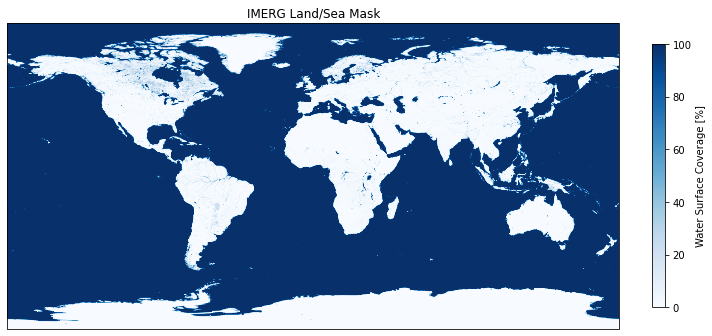

In [10]:
fig, ax = plt.subplots( 1, 1, figsize = (10, 5), subplot_kw = {'projection': ccrs.PlateCarree() } )
imerg_ds.surface_water_coverage.plot( ax = ax, cmap = 'Blues', cbar_kwargs = {'label': 'Water Surface Coverage [%]', 'fraction': 0.02 } )

plt.title( 'IMERG Land/Sea Mask' )
plt.tight_layout()
plt.show()

According to the [NASA page on the IMERG Land/Sea Mask](https://gpm.nasa.gov/data/directory/imerg-land-sea-mask-netcdf), a 75% water surface coverage is a typical thresold with which to define the open sea and coastal areas, which we will be using for our analyses. Using `where`, we can now replace any IMERG precipitation value over land with a NaN value to ignore it in calculations.

In [11]:
imerg_ds['precipitation'] = imerg_ds.precipitation.where(imerg_ds.surface_water_coverage >= 75) # Only utilize precipitation where surface weater coverage is at least 75%

We can then make a plot of mean annual IMERG precipitation to ensure that we've properly masked out the land, which we've traced out with the aid of `cartopy`'s built-in coastlines:

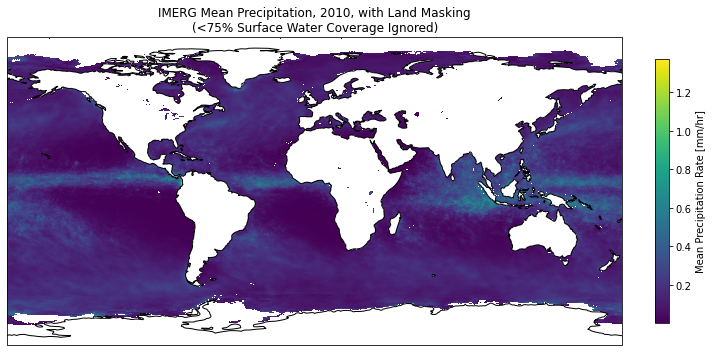

In [12]:
fig, ax = plt.subplots( 1, 1, figsize = (10, 5), subplot_kw = {'projection': ccrs.PlateCarree() } )
imerg_ds.precipitation.mean( 'time' ).plot( ax = ax, cbar_kwargs = {'label': 'Mean Precipitation Rate [mm/hr]', 'fraction': 0.02 } )
ax.coastlines()

plt.title( 'IMERG Mean Precipitation, 2010, with Land Masking\n(<75% Surface Water Coverage Ignored)' )
plt.tight_layout()
plt.show()

### IMERG Derived Fields

We've reached good starting point for our data, but it would be useful to append derived fields to the dataset instead of having just precipitation (and we'll see later that this is a *necessary* step if we want to have any hope of preserving the data when upscaling it!). One field we could add is the total precipitation at each grid cell (a measure of volume per hour). To do that, we will need to calculate the approximatesize of each gridbox. This computed area can be useful for other calculations, so we can store this value as a data variable within the `imerg_ds` dataset:

In [13]:
a = 6371e3 # The average radius of the Earth, in meters
lats = np.arange(-89.95, 89.96, 0.1) # Get a list of latitudes to compute gridbox sizes

# Degree step in latitude and longitude
dy_deg = 0.1
dx_deg = 0.1

dy = a * np.pi / ( 180 / dy_deg ) # Meridional distance per latitude

dx = ( 2 * np.pi * a / ( 360 / dx_deg ) ) * np.cos( np.radians( lats ) ) # Compute zonal distance at each latitude
dx = np.tile( dx, ( int( 360 / dx_deg ), 1 ) ) # Extend dx to indicate dx at each grid cell

In [14]:
# Compute cell area at each grid cell
cell_area = ( dx * dy ).T

# Create a DataArray of the cell areas and add it to the IMERG dataset
cell_area_array = xr.DataArray( cell_area, dims = ['lat', 'lon'], coords = { 'lon': imerg_ds.lon, 'lat': imerg_ds.lat } )
cell_area_array.attrs['units']='m**2'
imerg_ds['cell_area'] = cell_area_array

As a sanity check, we can sum the cell areas and compare them with known values. For a sphere of a 6371 km radius, as we defined earlier, the area should be around $5.1 \times 10^{14} \, \text{m}^2$.

In [15]:
print( 'Total Surface Area [m^2]', imerg_ds['cell_area'].sum().values ) # Check that total cell area is near 5.1e14

Total Surface Area [m^2] 510064536649207.06


Once we have added the area of each cell as a data variable to `imerg_ds`, we can then make area-aware calculations. For instance, we can estimate the total precipitation per grid cell (as a volume per hour, or volume rate) using the average precipitation total and the cell area. Let's add that as a `total_precipitation` variable to the dataset.

In [16]:
imerg_ds['total_precipitation'] = imerg_ds['precipitation'] / 1e3 * imerg_ds['cell_area'] # Compute total precipitation
imerg_ds['total_precipitation'].attrs['units'] = 'm**3/hr' # Set units on total precipitation

One last thing we should do regarding the land mask is to compute the estimated surface water area at each grid cell. This will be useful for when the IMERG data is upscaled, and will allow us to recompute the surface water fraction and mask the data at the lower spatial resolution. This is achievable now that we've derived cell areas. This data will be stored as the `cell_water_area` data variable. We should also ensure that the computed area of the surface water is about 71% of the total surface area of Earth:

In [17]:
imerg_ds['cell_water_area'] = imerg_ds.cell_area * ( imerg_ds.surface_water_coverage / 100 )
imerg_ds['cell_water_area'].attrs['units'] = 'm**2'

In [18]:
print( 'Total Surface Water Fraction', ( imerg_ds['cell_water_area'].sum() / imerg_ds['cell_area'].sum() ).values ) # Check that percentage is near 0.71

Total Surface Water Fraction 0.7197597348929203


### Upscaling IMERG

Currently, `imerg_ds` makes use of the full 0.1 x 0.1 degree resolution that the IMERG data was originally provided in. However, these areas are probably too small to make reasonable correlations with ship data, which is likely too sparse for a 0.1 x 0.1 degree grid to make much sense of. Instead, we will use a 5 x 5 degree grid. While `xESMF` could be used to achieve this, the IMERG data does not provide latitude and longitude bounds which would be needed for the ideal `conservative` regridding (this would be chosen instead of the other regridding methods due to its preservation of integrated totals).

In reality, we don't have to reconfigure the `imerg_ds` coordinate system to describe the cell edges. Instead, we can make use of a recently introduced function in xarray, [`coarsen`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.coarsen.html), to upscale our data. [This StackOverflow post](https://stackoverflow.com/questions/53886153/resample-xarray-object-to-lower-resolution-spatially) provided inspiration to upscale the spatial data in this manner. Having already computed integrated values on the native grid, we need not worry about cells being "lost" when upscaling.

When we check out the data again, we see that it is now on a coarser 72 x 36 grid as opposed to a finer but more cumbersome 3600 x 1800 grid.

In [19]:
imerg_5x5_ds = imerg_ds.coarsen(lat=50, lon=50).sum() # Upscale to a 5 x 5 degree grid ( 50 x 50 0.1 x 0.1 boxes )
imerg_5x5_ds

<xarray.Dataset>
Dimensions:                 (time: 12, lat: 36, lon: 72)
Coordinates:
  * lat                     (lat) float32 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * lon                     (lon) float32 -177.5 -172.5 -167.5 ... 172.5 177.5
  * time                    (time) object 2010-01-01 00:00:00 ... 2010-12-01 ...
Data variables:
    precipitation           (time, lat, lon) float32 dask.array<chunksize=(1, 36, 72), meta=np.ndarray>
    surface_water_coverage  (lat, lon) float32 0.0 0.0 579.9 ... 2.5e+05 2.5e+05
    cell_area               (lat, lon) float64 1.348e+10 1.348e+10 ... 1.348e+10
    total_precipitation     (time, lat, lon) float64 dask.array<chunksize=(1, 36, 72), meta=np.ndarray>
    cell_water_area         (lat, lon) float64 0.0 0.0 ... 1.348e+10 1.348e+10
Attributes:
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-MONTH/06;\nDOIa...
    FileInfo:                        DataFormatVersion=6a;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         2022-12-14 05:09:38 GMT Hyrax-1.16.3 htt...

`cell_area`, `cell_water_area`, and `total_precipitation` are integrated totals, so summing up their values from the original grid to produce a larger grid box in the lower resolution grid makes sense. However, summing up the `precipitation` variable in this way does not make much sense. Instead, we should recompute `precipitation` to mean the average precipitation in the new 5 x 5 degree gridboxes, and we can do this by using our derived fields:

In [20]:
# Compute average precipitation as the total precipitation in the grid box divided by the cell area.
# Multiply by 1000 to get [mm/hr], since total_precipitation and cell_area are in meters
imerg_5x5_ds['precipitation'] = imerg_5x5_ds.total_precipitation / imerg_5x5_ds.cell_area * 1000
imerg_5x5_ds['precipitation'].attrs['units'] = 'mm/hr'

We need to also recompute the `cell_water_area` using our aggregated cell areas, since summing up individual percentage values does not have much physical meaning.

In [21]:
# Compute percentage of each grid cell covered by surface water
imerg_5x5_ds['surface_water_coverage'] = imerg_5x5_ds.cell_water_area * 100 / imerg_5x5_ds.cell_area
imerg_5x5_ds['surface_water_coverage'].attrs['units'] = '%'

With the new surface water coverage computed, we can re-mask regions with less than 75% surface water coverage.

In [22]:
# Only utilize precipitation where surface weater coverage is at least 75%
imerg_5x5_ds['precipitation'] = imerg_5x5_ds.precipitation.where(imerg_5x5_ds.surface_water_coverage >= 75)

### Visualizing/Analyzing IMERG

The resampled, lower resolution IMERG dataset can be used to produce visualizations of monthly global precipitation on a 5 x 5 degree global grid using `matplotlib` and `cartopy`, which will help us understand the data we are looking at and will allow us to more clearly gauge how the IMERG satellite data compares with the ICOADS ship data.

In [23]:
# Define coordinate reference systems
proj_crs = ccrs.Robinson( central_longitude = 180 ) # Define the projection CRS, which we will use for global visualizations
imerg_crs = ccrs.PlateCarree() # Define the data CRS for IMERG

/tmp/ipykernel_69843/1379234460.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


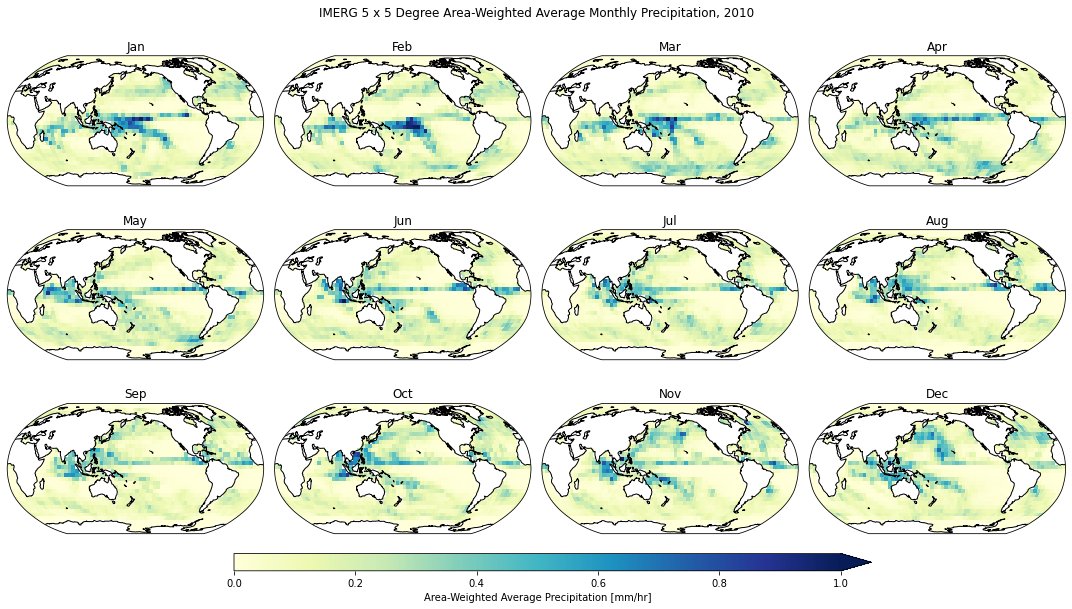

In [24]:
fig, axs = plt.subplots( 3, 4, figsize = (15, 8), subplot_kw = {'projection': proj_crs} )

# Plot each month's IMERG precipitation estimate in each subplot
for ax, dt in zip( axs.flatten(), imerg_5x5_ds.time.values ):
    pc = ax.pcolormesh( imerg_5x5_ds.lon, imerg_5x5_ds.lat, imerg_5x5_ds.precipitation.sel(time = dt),
                  transform = imerg_crs, cmap = 'YlGnBu', vmin = 0, vmax = 1 )
    ax.set_title( dt.strftime('%b') )
    ax.coastlines()

# Add colorbar axis and colorbar mappable
cax = fig.add_axes( [0.22, 0, 0.59, 0.03] )
cbar = plt.colorbar(pc, cax = cax, orientation='horizontal', extend = 'max' )
cbar.set_label( 'Area-Weighted Average Precipitation [mm/hr]' )

fig.suptitle('IMERG 5 x 5 Degree Area-Weighted Average Monthly Precipitation, 2010')
plt.tight_layout()
plt.show()

Even in the coarser 5 x 5 degree grid, we're able to extract spatial features in the IMERG data, and our effort of masking the over-land data allows us to focus on precipitation patterns at sea during 2010. The north-south drift of the Intertropical Convergence Zone is evident in these plots, as are the movements of the subtropical ridges. A stand-out feature is the large blob of precipitation in the Central Pacific in the February plot. Perhaps this will be evident in the qualitative ship observations as well?

The GPM satellites used to construct the IMERG dataset don't pass over all regions of Earth equitably. However, over the course of a month, or the course of a year, all regions of the Earth are covered. This is not true of ICOADS ship data, where it is expected that some regions may have very little data (such as hostile seas or areas away from the main shipping routes). To examine how well-sampled the global precipitation distribution is, we can use a histogram and cumulative distribution function of the IMERG precipitation data to see how low-precipitation and high-precipitation regions are distributed and represented.

> **Note**: The technique of sorting a dataset as part of plotting a cumulative distribution function was inspired by [this Geeksforgeeks.org page](https://www.geeksforgeeks.org/how-to-calculate-and-plot-a-cumulative-distribution-function-with-matplotlib-in-python/). The more Pythonic method of removing all NaN values in a numpy array was taken from [this StackOverflow page](https://stackoverflow.com/questions/11620914/how-do-i-remove-nan-values-from-a-numpy-array).

In [25]:
# Get a flattened list of all IMERG 2010 data, independent of their time or location
imerg_precipitation_values = np.sort( imerg_5x5_ds.precipitation.values.flatten() )
imerg_precipitation_values = imerg_precipitation_values[~np.isnan(imerg_precipitation_values)] # Drop NaN values

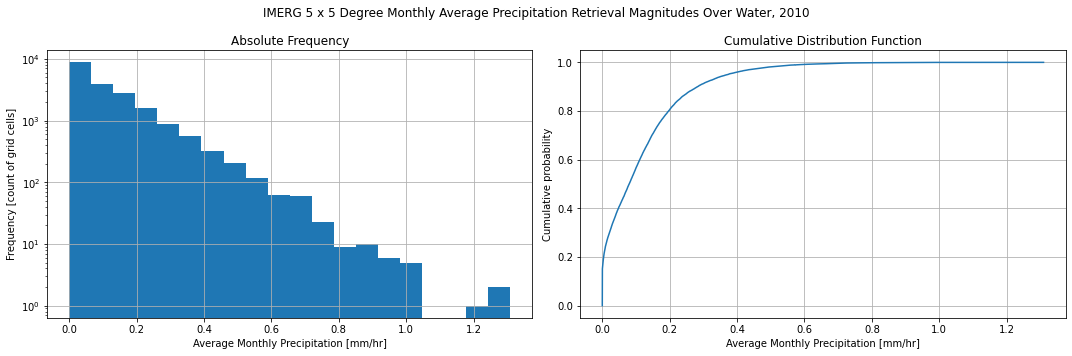

In [26]:
fig, axs = plt.subplots( 1, 2, figsize = ( 15, 5 ), sharex = True )

for ax in axs.flatten():
    ax.grid()
    ax.set_xlabel( 'Average Monthly Precipitation [mm/hr]' )

# Plot the overall histogram of the data
counts = axs[0].hist( imerg_precipitation_values, bins = 20 ) # Plot histogram of all spatial and temporal IMERG data points

axs[0].set_title( 'Absolute Frequency' )
axs[0].set_ylabel( 'Frequency [count of grid cells]' )
axs[0].set_yscale('log') # Change the y-axis to logarithmic

# Plot a cumulative distribution function
cdf_y = np.linspace( 0, 1, imerg_precipitation_values.size )

axs[1].set_title( 'Cumulative Distribution Function' )
axs[1].plot( imerg_precipitation_values, cdf_y )
axs[1].set_ylabel('Cumulative probability')

plt.suptitle( 'IMERG 5 x 5 Degree Monthly Average Precipitation Retrieval Magnitudes Over Water, 2010' )
plt.tight_layout()
plt.show()

The IMERG data appears to be approximately logarithmic, with most grid cells receiving very little precipitation. Grid cells showing monthly mean precipitation exceeding 0.2 mm/hr represent less than 20% of the IMERG dataset for 2010, and monthly mean precipitation exceeding 0.4 mm/hr represent less than 5% of the dataset. According to IMERG, the seas tend to not feature precipitation.

Information regarding the overall dataset distribution can be quantified as opposed to visualized for comparison with ICOADS data characteristics. We can use the [`describe`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.describe.html) function from `scipy.stats` to highlight some summary information:

In [27]:
print( '2010, All Data Points' )
print( stats.describe( imerg_precipitation_values ) )
print( 'IQR: %.3f'%stats.iqr( imerg_precipitation_values ) )

2010, All Data Points
DescribeResult(nobs=19356, minmax=(0.0, 1.309295219946507), mean=0.11484054069940039, variance=0.016840191379116215, skewness=1.8929614383150022, kurtosis=5.347025587139731)
IQR: 0.159


It is also useful to see how the satellite-derived global precipitation varies by month in aggregate, which may help gauge how well ship observations are sampling precipitation over the course of a year. The raw values (in meters per hour) are more difficult to compare with the ICOADS data, so instead we will look at how each months deviates in percentage from the global monthly volume flow rate:

In [28]:
monthly_global_volume = imerg_5x5_ds.total_precipitation.sum( ['lat', 'lon'] ).values # Compute the total global volume flow rate of precipitation by month
monthly_global_volume_mean = monthly_global_volume.mean() # Compute the average monthly global precipitation volume

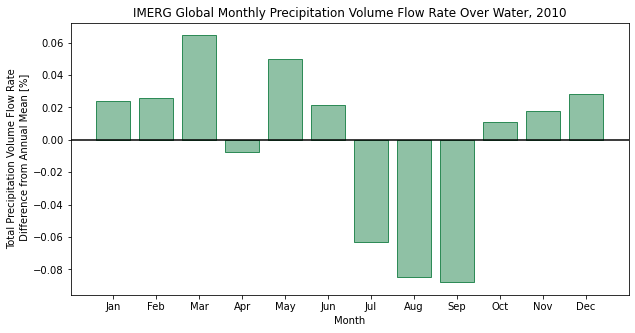

In [29]:
fig = plt.figure( figsize = (10, 5) )

# Create a bar chart
plt.bar( np.arange( 1, 13, 1 ), ( monthly_global_volume - monthly_global_volume_mean ) / monthly_global_volume_mean, facecolor = '#2e8b5788', edgecolor = 'seagreen' )
plt.xticks( ticks = np.arange( 1, 13, 1 ), labels = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] )

plt.axhline(0, color = 'k')
plt.title( 'IMERG Global Monthly Precipitation Volume Flow Rate Over Water, 2010' )
plt.xlabel( 'Month' )
plt.ylabel( 'Total Precipitation Volume Flow Rate\n Difference from Annual Mean [%]' )
plt.show()

The global monthly precipitation volume flow rate in IMERG stays within 5% of the annual average, with the late boreal summer and early boreal autumn showing a large deficit in global precipitation relative to the global mean while the winter months and late boreal spring showing the largest relative surplus in global precipitation.

We then plot the annual mean precipitation for 2010 to get a sense of the global precipitation distribution. To more clearly see the structure of spatial features (especially given the resampled, lower resolution grid), we can produce a `contourf` plot instead of a `pcolormesh` plot. However, to do so, we will first need to use the `add_cyclic_point` function from `cartopy` to bridge the data across the 180th meridian and allow contours to cross that meridian.

In [30]:
imerg_5x5_precip_ann_cyclic, cyclic_5x5_lons = cutil.add_cyclic_point( imerg_5x5_ds.precipitation.sum( 'time' ), coord = imerg_5x5_ds.lon )

In [31]:
# Calculate the global annual mean precipitation using the total precipitation volume divided by Earth water area
# Multiply by 1000 to get a result in mm/hr
global_ann_mean_precip = ( imerg_5x5_ds.total_precipitation.sum() / imerg_5x5_ds.cell_water_area.sum() ) * 1000

And, plotting the annual mean precipitation for 2010, we find that 2010 generally shows the same spatial patterns as the [overall climatological mean](https://gpm.nasa.gov/data/imerg/precipitation-climatology), such as the prominence of the Intertropical Convergence Zone near the equator, the South Pacific Convergence Zone, the imprint of storm tracks off the US East Coast and Japan, and the lack of precipitation coincident with the position and size of subtropical highs. 

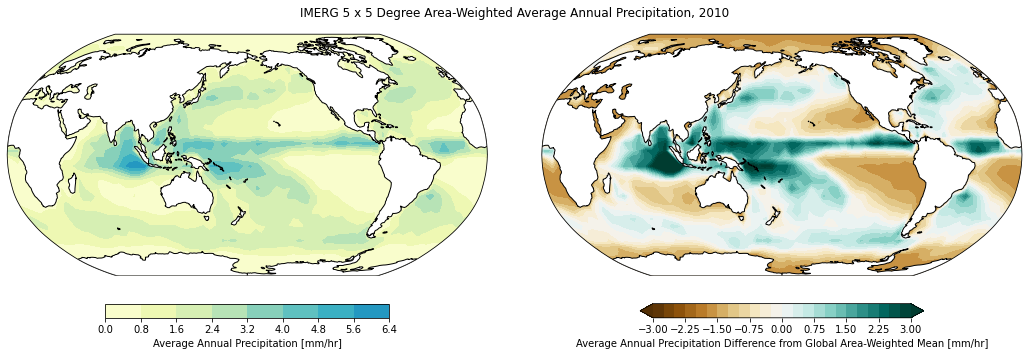

In [32]:
fig, axs = plt.subplots( 1, 2, figsize = (15, 5), subplot_kw = {'projection': proj_crs} )

for ax in axs.flatten():
    ax.add_feature( cfeature.LAND, zorder=5, facecolor = 'w', edgecolor = 'k' )

# Plot total precipitation
tot = axs[0].contourf( cyclic_5x5_lons, imerg_5x5_ds.lat, imerg_5x5_precip_ann_cyclic, 
                   transform = imerg_crs, cmap = 'YlGnBu', vmin = 0, vmax = 10 )
cbar = plt.colorbar( tot, ax = axs[0], orientation='horizontal', extend = 'max', fraction = 0.05, pad = 0.1 )
cbar.set_label( 'Average Annual Precipitation [mm/hr]' )

# Plot total precipitation, difference from mean
levels = np.linspace( -3, 3, 25 )
diff = axs[1].contourf( cyclic_5x5_lons, imerg_5x5_ds.lat, imerg_5x5_precip_ann_cyclic - global_ann_mean_precip, 
                   transform = imerg_crs, cmap = 'BrBG', levels = levels, vmin = -3, vmax = 3, extend = 'both' )
cbar = plt.colorbar( diff, ax = axs[1], orientation='horizontal', extend = 'both', fraction = 0.05, pad = 0.1 )
cbar.set_label( 'Average Annual Precipitation Difference from Global Area-Weighted Mean [mm/hr]' )

fig.suptitle('IMERG 5 x 5 Degree Area-Weighted Average Annual Precipitation, 2010')
plt.tight_layout()
plt.show()

As part of our guiding question, we would want to evaluate how IMERG compares to ICOADS data in disparate locations. We do not know a priori that correlations between the two datasets may be better or worse in regions with highly variable precipitation (such as areas with dramatic changes between wet/dry seasons) or regions with consistent precipitation year-round (such as in arid climates). To aid in the diagnosis of regions where an IMERG-ICOADS correlation may perform better, we can look at the standard deviation of monthly average rainfall in 2010. As above, we will first make the data cyclic to better visualize coherent spatial features, if they exist.

In [33]:
imerg_5x5_precip_std_cyclic = cutil.add_cyclic_point( imerg_5x5_ds.precipitation.std('time'), coord = imerg_5x5_ds.lon )

/opt/anaconda3/envs/aos573/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


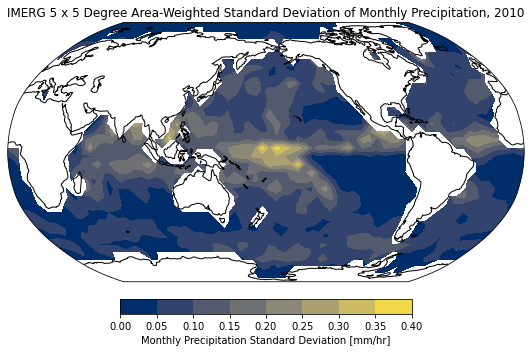

In [34]:
fig, ax = plt.subplots( 1, 1, figsize = (10, 5), subplot_kw = {'projection': proj_crs} )

pc = ax.contourf( cyclic_5x5_lons, imerg_5x5_ds.lat, imerg_5x5_precip_std_cyclic[0], transform = imerg_crs, cmap = 'cividis' )
ax.coastlines()
cbar = plt.colorbar( pc, ax = ax, orientation='horizontal', extend = 'max', fraction = 0.05, pad = 0.06 )
cbar.set_label( 'Monthly Precipitation Standard Deviation [mm/hr]' )

plt.title( 'IMERG 5 x 5 Degree Area-Weighted Standard Deviation of Monthly Precipitation, 2010' )
plt.tight_layout()
plt.show()

Based on the [Oceanic Nino Index (ONI)](https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php), 2010 was a year that transitioned from a moderately strong El Nino at the beginning of the year to a moderately strong La Nina by the year's end. Unsurprisingly, the region of greatest variance is the central Pacific, which transitioned from a region of high precipitation during the early-year El Nino period to a region of low precipitation during the late-year La Nina. The subtropics are unsurprisingly regions of low precipitation variance.

Passive microwave sensors typically underestimate precipitation at high-latitudes due to their lack of sensitivity to the weak precipitation (e.g. [Behrangi (2020)](https://link.springer.com/chapter/10.1007/978-3-030-35798-6_21)). Thus, a useful quantification of the IMERG data is to look at the zonal mean precipitation estimate. We can also examine these plots for both the original, 0.1 x 0.1 degree data to see how our aggregated, upscaled data has modified the initial dataset. 
> **Note**: This plot draws inspiration from Homework 5

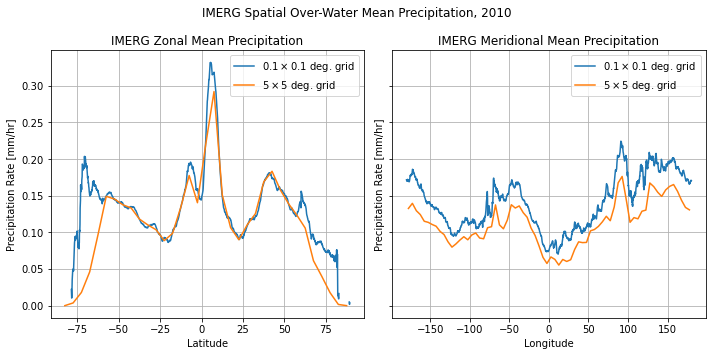

In [35]:
fig, axs = plt.subplots( 1, 2, figsize = (10, 5 ), sharey = True )

# Plot zonal means
imerg_ds.precipitation.mean( ['time', 'lon'] ).plot( ax = axs[0], label = r'$0.1 \times 0.1$ deg. grid')
imerg_5x5_ds.precipitation.mean( ['time', 'lon'] ).plot( ax = axs[0], label = r'$5 \times 5$ deg. grid')

axs[0].set_xlabel('Latitude')
axs[0].set_title( 'IMERG Zonal Mean Precipitation' ) 

# Plot meridional means
imerg_ds.precipitation.mean( ['time', 'lat'] ).plot( ax = axs[1], label = r'$0.1 \times 0.1$ deg. grid')
imerg_5x5_ds.precipitation.mean( ['time', 'lat'] ).plot( ax = axs[1], label = r'$5 \times 5$ deg. grid')

axs[1].set_title( 'IMERG Meridional Mean Precipitation' ) 
axs[1].set_xlabel('Longitude')

# Common features to both subplots
for ax in axs.flatten():
    ax.set_ylabel('Precipitation Rate [mm/hr]')
    ax.legend()
    ax.grid()
    
plt.suptitle( 'IMERG Spatial Over-Water Mean Precipitation, 2010' )
plt.tight_layout()
plt.show()

The zonal mean precipitation data shows a very clear two-maxima feature near the equator. This may be physically interpreted as the imprint of the SPCZ and the north-biased ITCZ. Secondary peaks in the mid-latitudes appear to be associated with common storm tracks, while the deficits in the subtropics appear to be associated with the lack of precipitation coincident with the positions of the subtropical hghs. This distribution of zonal means is frequently recreated in precipitation climatologies and well-represented in climate models, so it gives us tangible features in latitude space which hopefully can be represented in ICOADS as well.

On the other hand, there are less clear features in the meridional mean data, though we can see the deficit near 0° associated with the predominance of landmasses and the dry Mediterranean Sea, or the elevated precipitation in the Bay of Bengal and the Western and Central Pacific.

## Exploring the ICOADS Dataset (and comparing with IMERG)

It is now time to examine what is probably the simpler but harder to spatially reason dataset: qualitative ship reports of the present weather. The ICOADS dataset used for this analysis is a very large listing of numerous ship observations from 2010 identified by the time and location of observation. Using `pandas` is sensible for such data types. We can see that when we load the data in and print the resulting pandas dataframe:

In [36]:
# TODO: File extraction
icoads_df = pd.read_csv('icoads2010.csv')
icoads_df # Display the dataframe to get a sense of the data

,YR,MO,DY,HR,LAT,LON,WW
0,2010,1,1,0.00,81.4,215.3,39
1,2010,1,1,0.00,70.8,40.8,86
2,2010,1,1,0.00,66.3,7.4,2
3,2010,1,1,0.00,65.3,7.3,2
4,2010,1,1,0.00,65.2,1.1,2
...,...,...,...,...,...,...,...
809391,2010,12,31,23.00,-34.1,167.3,3
809392,2010,12,31,23.00,-35.0,304.1,-1
809393,2010,12,31,23.00,-38.6,140.9,1
809394,2010,12,31,23.00,-70.1,358.6,2


Many of the columns are added by NCAR as quality flags. When we ordered the data, NCAR already filtered out the data using its Enhanced Filtering rules, so we could go ahead and drop those columns. To reduce the submission file size, I took care of this column dropping beforehand, so the following code segment has been commented out.

In [37]:
# icoads_df = icoads_df.drop( ['DCK', 'SID', 'PT', 'IX', 'UID', 'RN1', 'RN2', 'RN3', 'RSA', 'IRF'] , axis = 1 )

The remaining `YR`, `MO`, `DY`, `HR`, `LAT`, `LON`, and `WW` fields represent the ship observation's year, month, day, hour, latitude, longitude, and present weather code.

### Adjusting and Classifying the ICOADS Data

The IMERG datase stored its longitudes as negative values for the western hemisphere and postiive values for the eastern hemisphere. To keep things consistent, we'll create a column `LON2` that will contain the shifted longitude coordinate system, and preserve the current `LON` field just in case.

In [38]:
icoads_df['LON2'] = icoads_df['LON'] # First, duplicate the LON field
icoads_df.loc[icoads_df['LON2'] >= 180, 'LON2'] -= 360 # Set values in the western hemisphere negative

The `WW` code is the present weather code (ranging from 0 to 99, with -1 representing missing values) and describes the weather occurring at the time of observation. As linked earlier, a listing of what those values mean is available in [this PDF documentation](https://icoads.noaa.gov/e-doc/imma/R3.0-imma1_short.pdf). As part of the analysis, we will be tagging these values using qualitative descriptors that will define broad precipitation classes, storing them under the column `PTYPE`. Below I've also defined some codes that constitute slight precipitation (which could be either snow or rain) and heavy precipitation (again, either snow or rain).

In [39]:
ww_slight = [60,61,66,68,70,71,80,83,85,86,87,89,91,93,95,96] # Codes representing light intensity precipitation
ww_heavy = [62,63,64,65,67,69,72,73,74,75,81,82,84,88,90,92,94,97,99] # Codes representing heavy precipitation

In [40]:
icoads_df.loc[icoads_df['WW'] < 50, 'PTYPE'] = '0-NoPrecip'
icoads_df.loc[icoads_df['WW'].between(50,59), 'PTYPE'] = '1-Drizzle'
icoads_df.loc[icoads_df['WW'].isin( ww_slight ), 'PTYPE'] = '2-SlightPrecip'
icoads_df.loc[icoads_df['WW'].isin( ww_heavy ), 'PTYPE'] = '3-HeavyPrecip'
icoads_df.loc[icoads_df['PTYPE'].isnull(), 'PTYPE'] = '4-Other' # Reports of other phenomena that aren't clearly non-precipitating

### A First Look at the ICOADS Data

While we can't plot a histogram off of qualitative data, we might be able to get a sense of some intensity distribution by plotting a histogram of the present weather code. Generally, higher present weather codes represent more intense precipitation phenomena, though this is not necessarily true; we can still infer some information about the ICOADS global precipitation intensity characteristics by seeing how much of a particular type of weather report is represented:

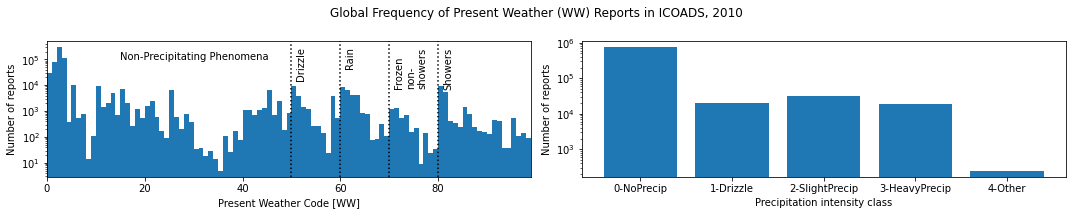

In [41]:
fig, axs = plt.subplots( 1, 2, figsize = (15, 3) )

# Histogram plot by WW code
axs[0].hist( icoads_df.WW, bins = 100 )
axs[0].set_ylabel( 'Number of reports' )
axs[0].set_xlabel( 'Present Weather Code [WW]' )
axs[0].set_yscale('log')
axs[0].set_xlim([0,99])

axs[0].axvline(50, color = 'k', linestyle = ':')
axs[0].axvline(60, color = 'k', linestyle = ':')
axs[0].axvline(70, color = 'k', linestyle = ':')
axs[0].axvline(80, color = 'k', linestyle = ':')

axs[0].text( 15, 1e5, 'Non-Precipitating Phenomena' )
axs[0].text( 51, 3e5, 'Drizzle', verticalalignment = 'top', rotation = 'vertical' )
axs[0].text( 61, 3e5, 'Rain', verticalalignment = 'top', rotation = 'vertical' )
axs[0].text( 71, 3e5, 'Frozen\nnon-\nshowers', verticalalignment = 'top', rotation = 'vertical' )
axs[0].text( 81, 3e5, 'Showers', verticalalignment = 'top', rotation = 'vertical' )

# Binned bar plot by precipitation class (as defined in the previous code segments)
ptype_counts = icoads_df.PTYPE.value_counts( sort = False ).sort_index()
axs[1].bar( [0,1,2,3,4], ptype_counts.values )
axs[1].set_yscale('log')
axs[1].set_xticks( np.arange(0, 5, 1) )
axs[1].set_xticklabels(ptype_counts.index)
axs[1].set_xlabel( 'Precipitation intensity class' )
axs[1].set_ylabel( 'Number of reports' )

plt.suptitle( 'Global Frequency of Present Weather (WW) Reports in ICOADS, 2010' )
plt.tight_layout()
plt.show()

The vast majority of ship reports in 2010 indicated a lack of precipitation, and this is what we'd expect in terms of global precipitation frequency. Within the individual precipitation classes (drizzle, rain, frozen non-showers, and showers), there may be some logarithmic relationship between precipitation intensity and frequency of reports, which would line up with the global IMERG data. However, when binning all the weather types by intensity (the plot at right), this logarithmic relationship is less clear. Still, there appears to be a decrease in the number of reports relative to precipitation intensity, which seems reasonable.

While not as physically consistent as a CDF plot for IMERG-derived precipitation totals, we can produce a CDF of present weather codes following the same technique as earlier:

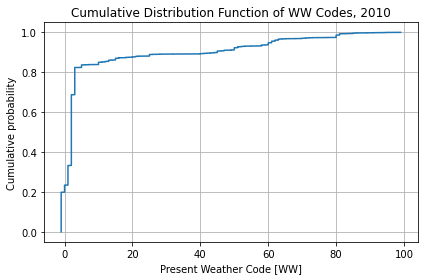

In [42]:
ww_values = np.sort( icoads_df.WW.values )
cdf_y = np.linspace( 0, 1, len(icoads_df) )

fig = plt.figure()

plt.title( 'Cumulative Distribution Function of WW Codes, 2010' )
plt.plot( ww_values, cdf_y )
plt.ylabel('Cumulative probability')
plt.xlabel('Present Weather Code [WW]')
plt.grid()

plt.tight_layout()
plt.show()

The non-monotonic ordering of the meaning of present weather codes means that this graph does not have much of a physical interpretation. However, what is noticeable is that the codes representing precipitation (WW greater than or equal to 50) account for only about 10% of the total ship observations. Part of this may be due to a *fair weather bias* in which mariners seek calmer, safer conditions that are less likely to feature precipitation.

We earlier looked at how satellite-derived precipitation totals varied by month. How are the above qualitative precipitation classes from ship reports distributed by month? Let's turn to Pandas' powerful `groupby` function to elucidate this. We'll drop the "Other" category, since they don't provide information on precipitation or non-precipitation.

> **Note**: [This GeeksForGeeks.org entry](https://www.geeksforgeeks.org/pandas-groupby-value-counts-on-the-dataframe/) was helpful for providing a method of counting occurrances of data entries.

In [43]:
# Get the number of precipitation classes in each month
ptype_by_month = icoads_df.groupby(['MO', 'PTYPE']).size().unstack(fill_value=0)
ptype_by_month = ptype_by_month.drop( ['4-Other'], axis = 1 ) # Drop the "other" precipitation class

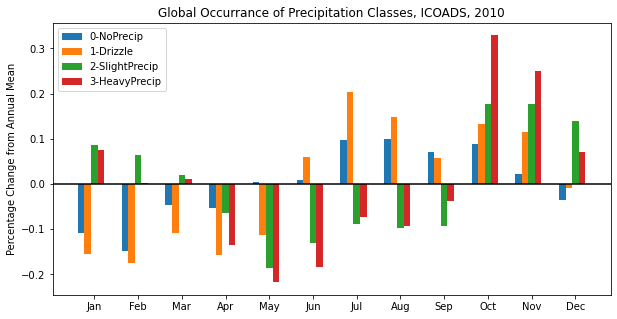

In [44]:
fig = plt.figure( figsize = (10, 5 ) )

shift = -0.3
for ptype in ptype_by_month:
    plt.bar( ptype_by_month.index + shift, ( ptype_by_month[ptype] - ptype_by_month[ptype].mean() ) / ptype_by_month[ptype].mean(),
           width = 0.15, label = ptype )
    shift += 0.15

plt.axhline(0, color = 'k')

plt.legend()
plt.xticks( np.linspace(1,12,12) )
plt.gca().set_xticklabels( ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] )
plt.ylabel( 'Percentage Change from Annual Mean' )
plt.title( 'Global Occurrance of Precipitation Classes, ICOADS, 2010' )
plt.show()

I was a little surprised to see that the ICOADS data somewhat lines up with the IMERG data. The no precipitation and drizzle precipitation classes, representing the weakest classes, are high relative to the annual mean in July to September, which is when the satellite-derived global precipitation mean was at its lowest. Additionally, the winter and fall months also show higher occurrances of the heavier precipitation classes, which echoes the elevated precipitation globally in those months in the IMERG data.

While there is no quantitative information associated with these precipitation classes, we might be able to derive some sort of weighted precipitation scoring, assigning 0 points to no precipitation, 1 point to drizzle, and so on. This might allow us to quantify the changes in precipitation month-to-month suggested by these precipitation classes:

In [45]:
pscore = ptype_by_month['1-Drizzle'] + 2 * ptype_by_month['2-SlightPrecip'] +  3 * ptype_by_month['3-HeavyPrecip']

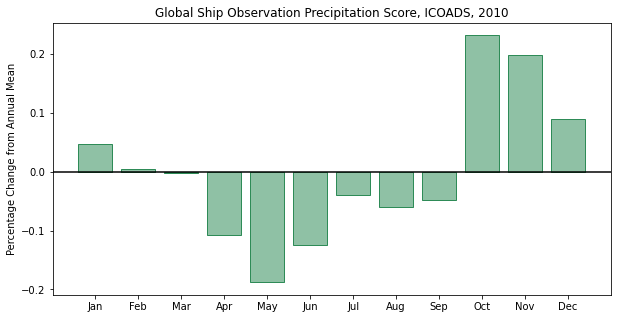

In [46]:
fig = plt.figure( figsize = (10, 5 ) )
plt.bar( pscore.index, ( pscore - pscore.mean() ) / pscore.mean(), facecolor = '#2e8b5788', edgecolor = 'seagreen' )
plt.axhline(0, color = 'k')

plt.xticks( np.linspace(1,12,12) )
plt.gca().set_xticklabels( ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] )
plt.ylabel( 'Percentage Change from Annual Mean' )
plt.title( 'Global Ship Observation Precipitation Score, ICOADS, 2010' )
plt.show()

Here we see some correspondance between the ICOADS precipitation scoring and the global IMERG volume flow rate of precipitation, particularly in highlighting that the winter months and late fall are wetter than the annual mean while the summer months are drier. However, it seems that the spring transitional period is lost in the ICOADS data.

### Spatially Binning ICOADS

We could dive right into analyzing the ICOADS data in a geospatial sense, but doing so with the data as it currently is could be problematic. One of the challenges of this analysis is that the ICOADS ship data are discrete, individual points, while the IMERG satellite-derived precipitation data is mapped to a regular grid with global coverage. Unlike a global gridded dataset, we expect ship data to be limited in spatial coverage, and biased towards major shipping routes. This would make trying to reason with the data at small scales a potentially futile effort.

For this analysis, it will be helpful to group ship data together into relatively large spatial bins (and we'll later do the same for the IMERG satellite-derived data). In this case, we will aggregate the ship data into 5 x 5 degree bins. To do this we will take advantage of the Matplotlib `hist2d` function, which we won't immediately plot but instead use its computed values to derive a "gridded" view of the ICOADS data.

In [47]:
xbins = np.arange(-180, 181, 5)
ybins = np.arange(-90, 91, 5)

# Create blank arrays
total_reports = []
drizzle_reports = []
slight_reports = []
heavy_reports = []

# Cycle through each month and add to the blank arrays
for month in np.linspace(1, 12, 12):
    # print(month) # This is to ensure progression of the loop
    
    # Partition monthly data by precipitation intensity class
    mo_df = icoads_df[icoads_df['MO'] == month]
    drizzle_df = mo_df[mo_df['PTYPE'] == '1-Drizzle']
    slight_df = mo_df[mo_df['PTYPE'] == '2-SlightPrecip']
    heavy_df = mo_df[mo_df['PTYPE'] == '3-HeavyPrecip']

    # Get spatial bins for the month
    total_mo, _, _ = np.histogram2d(mo_df.LON2, mo_df.LAT, bins = (xbins, ybins))
    drizzle_mo, _, _ = np.histogram2d(drizzle_df.LON2, drizzle_df.LAT, bins = (xbins, ybins))
    slight_mo, _, _ = np.histogram2d(slight_df.LON2, slight_df.LAT, bins = (xbins, ybins))
    heavy_mo, _, _ = np.histogram2d(heavy_df.LON2, heavy_df.LAT, bins = (xbins, ybins))
    
    # Transpose on append to keep latitude-first order
    total_reports.append( total_mo.T )
    drizzle_reports.append( drizzle_mo.T )
    slight_reports.append( slight_mo.T )
    heavy_reports.append( heavy_mo.T )

We can now make an xarray DataSet on the same grid as the IMERG 5x5 degree dataset, and from here on out we will treat the ICOADS data as gridded data rather than point data. We will use the same `(time, lat, lon)` convention from the initial IMERG dataset, which required us to previously take the transpose of each of the binned precipitation classes.

In [48]:
icoads_coords = { 'time': imerg_5x5_ds.time, 'lon': imerg_5x5_ds.lon, 'lat': imerg_5x5_ds.lat }

# Create data arrays for each precipitating class (exclude no-precip or other)
total_da = xr.DataArray(total_reports, dims = ['time', 'lat', 'lon'], coords = icoads_coords )
total_da.attrs['units'] = 'Number of observations'

drizzle_da = xr.DataArray(drizzle_reports, dims = ['time', 'lat', 'lon'], coords = icoads_coords )
drizzle_da.attrs['units'] = 'Number of observations'

slight_da = xr.DataArray(slight_reports, dims = ['time', 'lat', 'lon'], coords = icoads_coords )
slight_da.attrs['units'] = 'Number of observations'

heavy_da = xr.DataArray(heavy_reports, dims = ['time', 'lat', 'lon'], coords = icoads_coords )
heavy_da.attrs['units'] = 'Number of observations'

After making the DataArrays above, we can unify them into a Dataset:

In [49]:
icoads_ds = xr.Dataset( data_vars = {'total': total_da, 'drizzle': drizzle_da, 'slight': slight_da, 'heavy': heavy_da } )
icoads_ds

<xarray.Dataset>
Dimensions:  (time: 12, lon: 72, lat: 36)
Coordinates:
  * time     (time) object 2010-01-01 00:00:00 ... 2010-12-01 00:00:00
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
Data variables:
    total    (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    drizzle  (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    slight   (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    heavy    (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

We have now coerced the ICOADS data into an xarray that resembles the structure of the IMERG data, allowing for more direct comparisons between the two!

### Visualizing/Analyzing ICOADS

Let's now examine how the ship data is distributed spatially with our new gridded ICOADS dataset.

In [50]:
# Define coordinate reference systems
proj_crs = ccrs.Robinson( central_longitude = 0 ) # Define the projection CRS, which we will use for global visualizations
icoads_crs = ccrs.PlateCarree() # Define the CRS for the ICOADS data

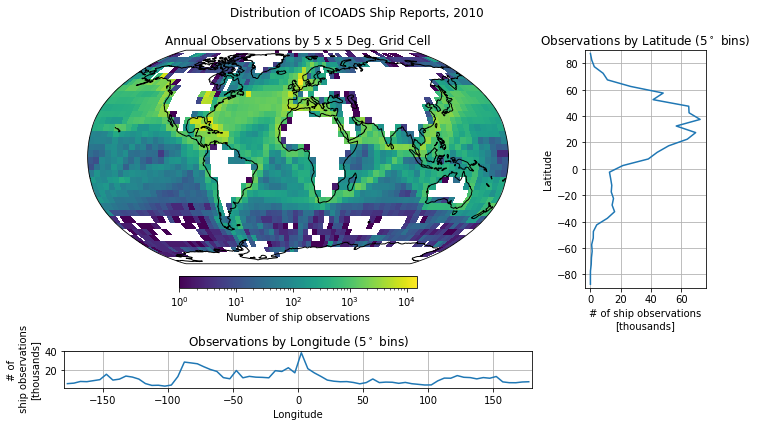

In [51]:
# Create a GridSpec and visualize the distribution of ICOADS data in 2010
gs = gridspec.GridSpec( nrows = 4, ncols = 4 )

fig = plt.figure( figsize = (10,6) )
ax1 = fig.add_subplot( gs[:3, :3], projection = proj_crs )
ax2 = fig.add_subplot( gs[:3, 3] ) # Zonal counts
ax3 = fig.add_subplot( gs[3, :3] ) # Meridional counts

ax1.set_title('Annual Observations by 5 x 5 Deg. Grid Cell')
pc = ax1.pcolormesh( icoads_ds.lon, icoads_ds.lat, icoads_ds.total.sum('time'), transform = icoads_crs,
              norm = colors.LogNorm() )
cb = plt.colorbar( pc, ax = ax1, orientation = 'horizontal', fraction = 0.05, pad = 0.05 )
cb.set_label( 'Number of ship observations' )
ax1.coastlines()
# gl = ax1.gridlines(draw_labels=True)
# gl.top_labels = False

ax2.set_title( 'Observations by Latitude (5$^\circ$ bins)' )
ax2.plot(icoads_ds.total.sum(['time','lon']) / 1e3, icoads_ds.lat)
ax2.set_ylim( [-90, 90] )
ax2.set_ylabel( 'Latitude' )
ax2.set_xlabel( '# of ship observations\n[thousands]' )
ax2.grid()

ax3.set_title('Observations by Longitude (5$^\circ$ bins)')
ax3.plot(icoads_ds.lon, icoads_ds.total.sum(['time','lat']) / 1e3)
ax3.set_xlim( [-180,180] )
ax3.set_ylabel( '# of\n ship observations\n[thousands]' )
ax3.set_xlabel( 'Longitude' )
ax3.grid()

plt.suptitle('Distribution of ICOADS Ship Reports, 2010')
plt.tight_layout()
plt.show()

Unsurprisingly, the data is concentrated around shipping lanes, and there is a preponderance of observations in the Northern Hemisphere. Global aggregate data is thus likely influenced more by the boreal seasons than the austral seasons.

How does the number of observations vary month to month? We can look at the standard deviation of report counts to measure month-to-month variability, just as we did for precipitation for the IMERG dataset:

In [52]:
# Remove meridian by applying cyclic points to the data
icoads_total_std_cyclic = cutil.add_cyclic_point( icoads_ds.total.std('time'), coord = imerg_5x5_ds.lon )

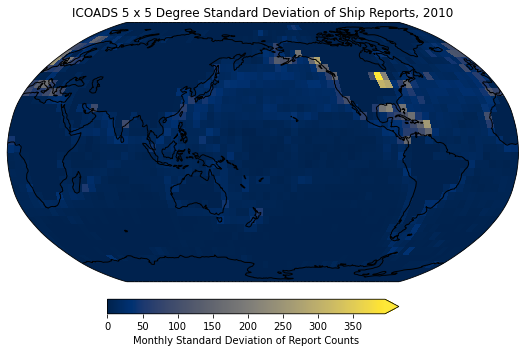

In [53]:
proj_crs = ccrs.Robinson( central_longitude = 180 )
fig, ax = plt.subplots( 1, 1, figsize = (10, 5), subplot_kw = {'projection': proj_crs} )

pc = ax.pcolormesh( cyclic_5x5_lons, icoads_ds.lat, icoads_total_std_cyclic[0], transform = icoads_crs, cmap = 'cividis' )
ax.coastlines()
cbar = plt.colorbar( pc, ax = ax, orientation='horizontal', extend = 'max', fraction = 0.05, pad = 0.06 )
cbar.set_label( 'Monthly Standard Deviation of Report Counts' )

plt.title( 'ICOADS 5 x 5 Degree Standard Deviation of Ship Reports, 2010' )
plt.tight_layout()
plt.show()

Unlike with IMERG precipitation, the ICOADS data frequency appears to have less variance spatially, though there are some areas, particularly around the Great Lakes and Caribbean, which may have high variance. Ideally, when looking for correlations between the ICOADS data and the IMERG data, we would want a region that sees a fairly consistent amount of reports year-round.

Let's now look at our precipitating ICOADS reports. A quantity that could be useful is calculating the fraction of reports in each 5 x 5 degree grid cell that are precipitating reports. Here, we'll make a new field in `icoads_ds` called `percent_precipitating` that stores this information:

In [54]:
icoads_ds['percent_precipitating'] = ( icoads_ds.drizzle + icoads_ds.slight + icoads_ds.heavy ) * 100 / icoads_ds.total
icoads_ds['percent_precipitating'].attrs['units'] = '%'

/tmp/ipykernel_69843/1500158165.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


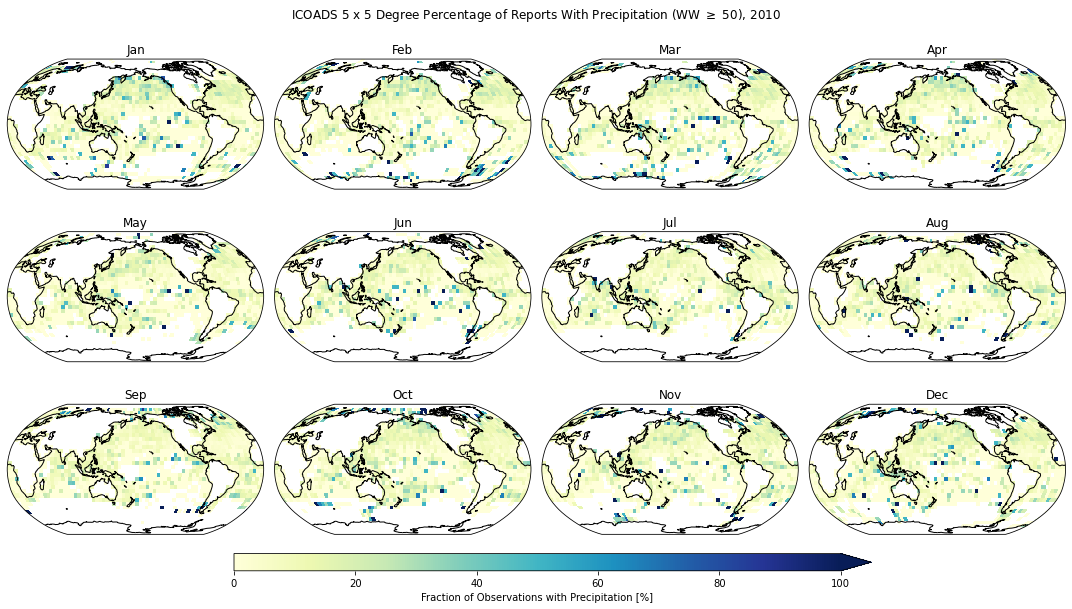

In [55]:
fig, axs = plt.subplots( 3, 4, figsize = (15, 8), subplot_kw = {'projection': proj_crs} )

# Plot each month's fraction of observations reporting precipitation in each subplot
for ax, dt in zip( axs.flatten(), icoads_ds.time.values ):
    pc = ax.pcolormesh( icoads_ds.lon, icoads_ds.lat, icoads_ds.percent_precipitating.sel(time = dt),
                  transform = icoads_crs, cmap = 'YlGnBu', vmin = 0, vmax = 100 )
    ax.set_title( dt.strftime('%b') )
    ax.coastlines()

# Add colorbar axis and colorbar mappable
cax = fig.add_axes( [0.22, 0, 0.59, 0.03] )
cbar = plt.colorbar(pc, cax = cax, orientation='horizontal', extend = 'max' )
cbar.set_label( 'Fraction of Observations with Precipitation [%]' )

fig.suptitle('ICOADS 5 x 5 Degree Percentage of Reports With Precipitation (WW $\geq$ 50), 2010')
plt.tight_layout()
plt.show()

Unfortunately, the spatial distribution of this precipitation fraction is much less coherent than the robust structures observed in the IMERG data. There is some signal of the ITCZ and the dry subtropics, but the associated data appears to be rather scattered. From this plot, it appears that month-to-month ICOADS data may not be sufficient to gain further insight into maritime precipitation patterns, at least over the course of a single year.

Alternatively, although the month-by-month breakdown of precipitation fraction doesn't seem to yield clear results, does the annual aggregate better approximate the IMERG data? Below, the annual fraction of ship observations with precipitation will be calculated and visualized:

In [56]:
# Annual, per grid cell fractions of observations with precipitation
icoads_ann_frac = ( icoads_ds.drizzle.sum('time') + icoads_ds.slight.sum('time') + icoads_ds.heavy.sum('time') ) * 100 / icoads_ds.total.sum('time')
icoads_ann_frac_cyclic, _ = cutil.add_cyclic_point( icoads_ann_frac, coord = icoads_ds.lon )

In [57]:
# Annual, global fraction of observations with precipitation
icoads_global_frac = ( icoads_ds.drizzle.sum() + icoads_ds.slight.sum() + icoads_ds.heavy.sum() ) * 100 / icoads_ds.total.sum()

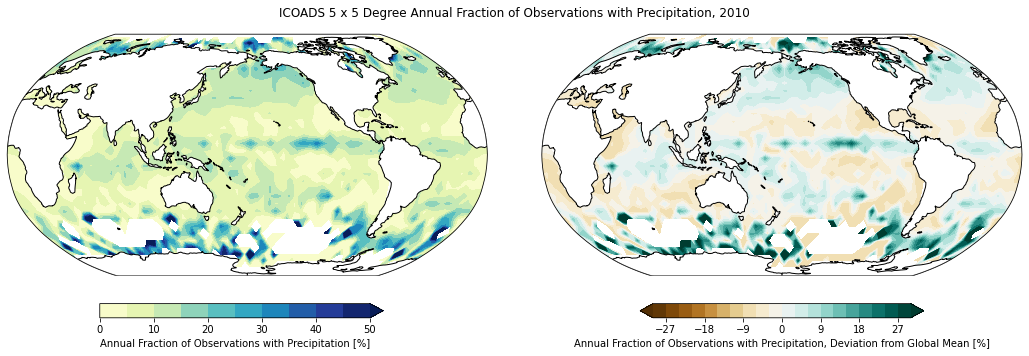

In [58]:
fig, axs = plt.subplots( 1, 2, figsize = (15, 5), subplot_kw = {'projection': proj_crs} )

for ax in axs.flatten():
    ax.add_feature( cfeature.LAND, zorder=5, facecolor = 'w', edgecolor = 'k' )

# Plot total fraction of precipitation
levels = np.linspace( 0, 50, 11 )
tot = axs[0].contourf( cyclic_5x5_lons, icoads_ds.lat, icoads_ann_frac_cyclic, 
                   transform = imerg_crs, cmap = 'YlGnBu', levels = levels, extend = 'max' )
cbar = plt.colorbar( tot, ax = axs[0], orientation='horizontal', extend = 'max', fraction = 0.05, pad = 0.1 )
cbar.set_label( 'Annual Fraction of Observations with Precipitation [%]' )

# Plot total fraction precipitating, difference from mean
levels = np.linspace( -30, 30, 21 )
diff = axs[1].contourf( cyclic_5x5_lons, icoads_ds.lat, icoads_ann_frac_cyclic - icoads_global_frac, 
                    transform = imerg_crs, cmap = 'BrBG', levels = levels, vmin = -30, vmax = 30, extend = 'both' )
cbar = plt.colorbar( diff, ax = axs[1], orientation='horizontal', extend = 'both', fraction = 0.05, pad = 0.1 )
cbar.set_label( 'Annual Fraction of Observations with Precipitation, Deviation from Global Mean [%]' )

fig.suptitle('ICOADS 5 x 5 Degree Annual Fraction of Observations with Precipitation, 2010')
plt.tight_layout()
plt.show()

The global composites plotted above is actually quite similar to the IMERG data, and it is worth noting that fraction of precipitation is not necessarily the same as precipitation rate, which is what the IMERG data seeks to estimate. Although the spatial features are much more diffuse, they are much more coherent annually in these plots of ICOADS data. The ITCZ is much more well-defined, and the SPCZ is diffuse but nonetheless apparent. Ships are probably avoiding the major storm tracks, but the imprint of those storm tracks are still somewhat apparent in the Northern Pacific and Northern Atlantic.

The prevalence of high precipitation fractions in the Southern Ocean is likely due in part to the lack of ship observations in that region. It may be of value to mask data from `icoads_ds` for regions with few total observations. Let's mask out areas with less than 100 total annual observations and repeat the preceding visualization to see if our suspicion was correct, creating a new dataset `icoads_filt_ds`:

In [59]:
icoads_filt_ds = icoads_ds.where( icoads_ds.total.sum('time') > 100 )

# Annual, per grid cell fractions of observations with precipitation
icoads_ann_frac = ( icoads_filt_ds.drizzle.sum('time') + icoads_filt_ds.slight.sum('time') + icoads_filt_ds.heavy.sum('time') ) * 100 / icoads_filt_ds.total.sum('time')
icoads_ann_frac_cyclic, _ = cutil.add_cyclic_point( icoads_ann_frac, coord = icoads_filt_ds.lon )

In [60]:
# Annual, global fraction of observations with precipitation
icoads_global_frac = ( icoads_filt_ds.drizzle.sum() + icoads_filt_ds.slight.sum() + icoads_filt_ds.heavy.sum() ) * 100 / icoads_filt_ds.total.sum()

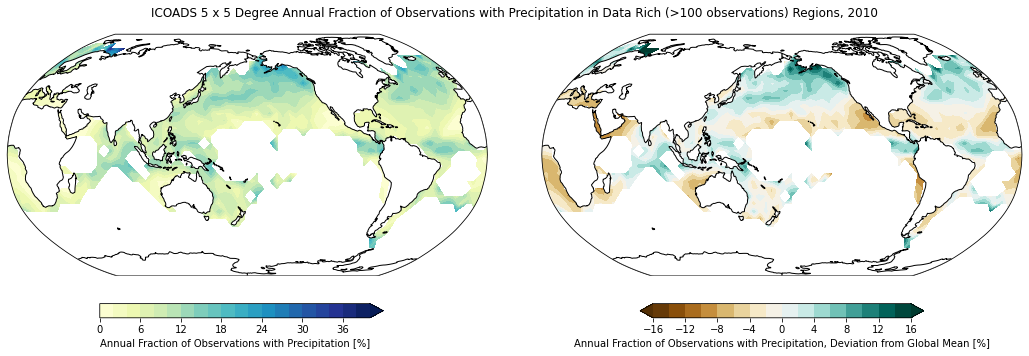

In [61]:
fig, axs = plt.subplots( 1, 2, figsize = (15, 5), subplot_kw = {'projection': proj_crs} )

for ax in axs.flatten():
    ax.add_feature( cfeature.LAND, zorder=5, facecolor = 'w', edgecolor = 'k' )

# Plot total fraction of precipitation
levels = np.linspace( 0, 40, 21 )
tot = axs[0].contourf( cyclic_5x5_lons, icoads_ds.lat, icoads_ann_frac_cyclic, 
                   transform = imerg_crs, cmap = 'YlGnBu', levels = levels, extend = 'max' )
cbar = plt.colorbar( tot, ax = axs[0], orientation='horizontal', extend = 'max', fraction = 0.05, pad = 0.1 )
cbar.set_label( 'Annual Fraction of Observations with Precipitation [%]' )

# Plot total fraction precipitating, difference from mean
levels = np.linspace( -16, 16, 17 )
diff = axs[1].contourf( cyclic_5x5_lons, icoads_ds.lat, icoads_ann_frac_cyclic - icoads_global_frac, 
                    transform = imerg_crs, cmap = 'BrBG', levels = levels, vmin = -16, vmax = 16, extend = 'both' )
cbar = plt.colorbar( diff, ax = axs[1], orientation='horizontal', extend = 'both', fraction = 0.05, pad = 0.1 )
cbar.set_label( 'Annual Fraction of Observations with Precipitation, Deviation from Global Mean [%]' )

fig.suptitle('ICOADS 5 x 5 Degree Annual Fraction of Observations with Precipitation in Data Rich (>100 observations) Regions, 2010')
plt.tight_layout()
plt.show()

Masking out the areas with low numbers of annual ship observations ($<100$ observations in 2010) highlights regions with the highest ship observation coverage in ICOADS and suggests that qualitative ship observations can provide decent coverage of large scale precipitation features over the course of a year; however, in 2010 this was most evident in the Northern Hemisphere, and coverage in the Southern Hemisphere was poor outside of key shipping routes. The plot at right shares many of the same spatial features as the 2010 annual plot of mean precipitation from IMERG. One key difference is that the ICOADS data shows elevated values of precipitation frequency in the Bering Sea and to the north of Scandinavia whereas the IMERG data showed precipitation deficits in those regions. This could be a signal of the poor performance of IMERG at high-latitudes, and may be a testament to the value of using qualitative ship observations to construct precipitation climatologies.

Using this filtered spatial ICOADS data, let's plot zonal and meridional aggregates of the fraction of observations with precipitation to see if we observed the same zonally or meridionally averaged features as in the IMERG data:

In [62]:
# Calculate zonal precipitation fractions
sum_axes = ['time', 'lon']
zonal_pct = ( icoads_filt_ds.drizzle.sum( sum_axes ) + icoads_filt_ds.slight.sum( sum_axes ) + icoads_filt_ds.heavy.sum( sum_axes ) ) * 100 / icoads_filt_ds.total.sum( sum_axes )

# Calculate meridional precipitation fractions
sum_axes = ['time', 'lat']
meridional_pct = ( icoads_filt_ds.drizzle.sum( sum_axes ) + icoads_filt_ds.slight.sum( sum_axes ) + icoads_filt_ds.heavy.sum( sum_axes ) ) * 100 / icoads_filt_ds.total.sum( sum_axes ) 

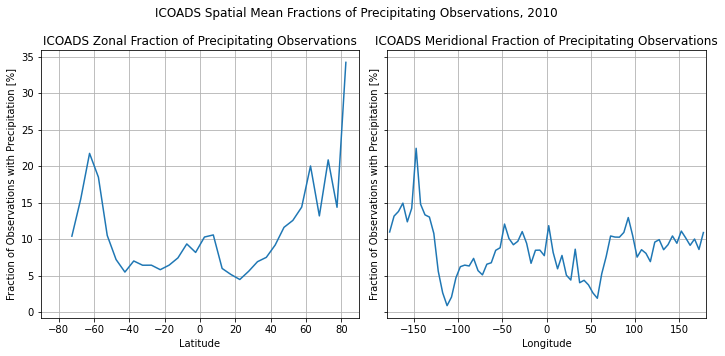

In [63]:
fig, axs = plt.subplots( 1, 2, figsize = (10, 5 ), sharey = True )

# Plot zonal means
zonal_pct.plot( ax = axs[0] )
axs[0].set_xlabel('Latitude')
axs[0].set_title( 'ICOADS Zonal Fraction of Precipitating Observations' ) 
axs[0].set_xlim( [-90, 90] )

# # Plot meridional means
meridional_pct.plot( ax = axs[1] )
axs[1].set_xlabel('Longitude')
axs[1].set_title( 'ICOADS Meridional Fraction of Precipitating Observations' ) 
axs[1].set_xlim( [-180, 180] )

# Common features to both subplots
for ax in axs.flatten():
    ax.set_ylabel('Fraction of Observations with Precipitation [%]')
    ax.grid()
    
plt.suptitle( 'ICOADS Spatial Mean Fractions of Precipitating Observations, 2010' )
plt.tight_layout()
plt.show()

Equatorward of the mid-latitudes, ICOADS manages to capture similar results as IMERG in the zonal mean data. There are two distinct maxima near the equator that are resolved by both ICOADS and IMERG, and placed and similar latitudes. The subtropical precipitation deficits centered at 25S and 25N are also represented in the 2010 ICOADS data. However, the key difference between IMERG and ICOADS in this data is that there is an increase in precipitation rate poleward of 40N/S, whereas precipitation tails off in the IMERG data. Again, this could be a signal that IMERG could be underestimating maritime precipitation in the high-latitudes. The meridional fractions for ICOADS in this case are not as meaningful for comparison with IMERG since most of the Southern Hemisphere is masked out due to poor data coverage. However, the general shape of the meridional averages is somewhat similar to the IMERG meridional averages.

## A Look at One Grid Cell

As shown above, even for just one year of data, the qualitative ICOADS data seems to show some utility in allowing one to determine aggregated spatial maritime precipitation patterns over the course of a year. However, can patterns at a singular grid point in ICOADS yield useful details about the precipitation at that location over the course of a year?

For this brief look at a singular grid cell, we'll look at (47.5N, 47.5W), which places us in a grid cell east of Newfoundland and over the North Atlantic, and visualize if variations in ICOADS ship reports line up with variations in satellite-derived precipitation estimates for that location. This location was chosen for having a relatively high number of observations year-round.

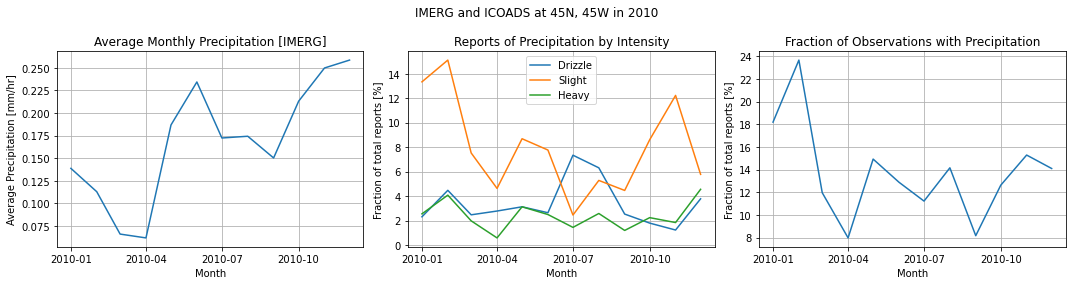

In [64]:
fig, axs = plt.subplots( 1, 3, figsize = (15, 4) )

imerg_5x5_ds.precipitation.sel(lat=47.5, lon=-47.5).plot(ax = axs[0])
axs[0].set_ylabel('Average Precipitation [mm/hr]')
axs[0].set_title('Average Monthly Precipitation [IMERG]')

(icoads_ds.drizzle.sel(lat=47.5, lon=-47.5) * 100 / icoads_ds.total.sel(lat=47.5, lon=-47.5)).plot(ax = axs[1], label = 'Drizzle')
(icoads_ds.slight.sel(lat=47.5, lon=-47.5) * 100 / icoads_ds.total.sel(lat=47.5, lon=-47.5)).plot(ax = axs[1], label = 'Slight')
(icoads_ds.heavy.sel(lat=47.5, lon=-47.5) * 100 / icoads_ds.total.sel(lat=47.5, lon=-47.5)).plot(ax = axs[1], label = 'Heavy')
axs[1].set_title('Reports of Precipitation by Intensity')
axs[1].set_ylabel('Fraction of total reports [%]')
axs[1].legend()

icoads_ds.percent_precipitating.sel(lat=47.5, lon=-47.5).plot(ax = axs[2])
axs[2].set_title('Fraction of Observations with Precipitation')
axs[2].set_ylabel('Fraction of total reports [%]')

for ax in axs:
    ax.set_xlabel('Month')
    ax.grid()

plt.suptitle('IMERG and ICOADS at 45N, 45W in 2010')
fig.tight_layout()
plt.show()

At a glance, the relationship between the average monthly precipitation at 45N, 45W does not appear strongly correlated to the proportions of intense precipitation reports from ships in ICOADS. However, there appears to be some similarities between the monthly precipitation and the fraction of observations with precipitation, with both showing a deficit in the late spring and in the early autumn. The possible similarities between qualitative data from ships and quantitative data from satellite estimates, particularly those highlighted in the spatial ICOADS analysis above, give me hope that ICOADS can be used as a springboard to construct pre-satellite precipitation climatologies over the ocean.